In [1]:
import networkx as nx
import numpy as np
from queue import PriorityQueue
from utils import *
import random
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import ipywidgets as widgets  # Add for UI
from IPython.display import display, clear_output, HTML  # Add for UI
import logging  # Add for logging

In [2]:
# Configure logging to output to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)
def add_node_with_edges(graph, node_name):
    """
    Add a node to the graph and allow the user to input related edges with direction using widgets in Jupyter Notebook.
    Displays immediate edge information on addition and logs actions to console.

    Parameters:
    graph (nx.DiGraph): The directed graph to add the node and edges to.
    node_name (str): The name of the node to add.

    Returns:
    None
    """
    # Add the node to the graph
    graph.add_node(node_name)
    display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
    logger.info(f"Node '{node_name}' has been added to the graph.")

    # Define output widget
    global node_dropdown, user_text, root_text, direction_dropdown, output
    output = widgets.Output()

    # Function to handle edge addition
    def add_edge(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
            logger.info(f"Add Edge button clicked for node '{node_name}'.")

            try:
                # Get widget values
                target_node = node_dropdown.value
                user_prob = float(user_text.value)
                root_prob = float(root_text.value)
                direction = direction_dropdown.value

                # Validate probabilities
                if not (0.0 <= user_prob <= 1.0 and 0.0 <= root_prob <= 1.0):
                    display(HTML("<b>Error:</b> Probabilities must be in the range [0.0, 1.0]. Please try again."))
                    logger.error(f"Invalid probabilities: user={user_prob}, root={root_prob}")
                    return

                # Prepare edge information
                edge_info = f"Edge Info: user={user_prob}, root={root_prob}, direction={direction}"

                # Add edge based on direction
                if direction == "To Target":
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{node_name}' to '{target_node}' ({edge_info})"
                elif direction == "From Target":
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{target_node}' to '{node_name}' ({edge_info})"
                else:  # Bidirectional
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Bidirectional edge between '{node_name}' and '{target_node}' ({edge_info})"

                # Display and log edge info immediately
                display(HTML(f"<b>Notification:</b> {edge_msg} has been added."))
                logger.info(f"{edge_msg} has been added.")
                display_widgets()  # Redisplay widgets for next edge
            except ValueError:
                display(HTML("<b>Error:</b> Invalid input for probabilities. Please enter valid numbers."))
                logger.error("Invalid input for probabilities.")

    # Function to handle stopping
    def stop_adding(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Finished adding edges for node '{node_name}'."))
            logger.info(f"Finished adding edges for node '{node_name}'.")

    # Function to display widgets
    def display_widgets():
        with output:
            clear_output(wait=True)
            # Get list of existing nodes
            existing_nodes = list(graph.nodes())
            if not existing_nodes:
                display(HTML("<b>Warning:</b> No existing nodes in the graph."))
                logger.warning("No existing nodes in the graph.")
                return

            # Create widgets
            global node_dropdown, user_text, root_text, direction_dropdown
            node_dropdown = widgets.Dropdown(
                options=existing_nodes,
                description='Target Node:',
                disabled=False
            )
            user_text = widgets.FloatText(
                value=0.0,
                description='User Prob:',
                style={'description_width': 'initial'}
            )
            root_text = widgets.FloatText(
                value=0.0,
                description='Root Prob:',
                style={'description_width': 'initial'}
            )
            direction_dropdown = widgets.Dropdown(
                options=["To Target", "From Target", "Bidirectional"],
                description='Edge Direction:',
                disabled=False
            )
            add_button = widgets.Button(description="Add Edge")
            stop_button = widgets.Button(description="Stop")

            # Assign button callbacks with debug logging
            def on_add_button_clicked(b):
                logger.info("Add Edge button event triggered.")
                add_edge(b)

            def on_stop_button_clicked(b):
                logger.info("Stop button event triggered.")
                stop_adding(b)

            add_button.on_click(on_add_button_clicked)
            stop_button.on_click(on_stop_button_clicked)

            # Display widgets and initial message
            display(HTML(f"<b>Adding edges from/to '{node_name}':</b>"))
            display(node_dropdown, user_text, root_text, direction_dropdown, add_button, stop_button)

    # Initial display of widgets
    display(output)
    display_widgets()

In [3]:
# Original graph setup
G_original = nx.DiGraph()
G_original.add_nodes_from(["Attacker", "Data Server"])

edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]
G_original.add_edges_from(edges)

add_node_with_edges(G_original, "New node")


2025-07-10 21:40:41,007 - INFO - Node 'New node' has been added to the graph.


Output()

In [4]:
def train_dqn(env, num_episodes, batch_size=10, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    global best_checkpoint, best_episode
    state_size = env.num_nodes
    action_space_size = env.get_action_space_size()
    print('state_size', state_size)
    print('action_space_size', action_space_size)
    # Initialize DQN and target network
    policy_net = DQN(state_size, action_space_size)
    target_net = DQN(state_size, action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    replay_buffer = ReplayBuffer(capacity=10000)
    epsilon = epsilon_start
    total_reward = 0
    dsp = 0
    best_dsp = 0
    interval_check = num_episodes // 10  # Mỗi num_episodes/10
    interval_save = num_episodes // 5   # Lưu sau mỗi num_episodes/5

    for episode in range(1, num_episodes+1):
        state = env.reset()
        done = False

        exploration_counter = defaultdict(int)

        while not done:
            if random.random() < epsilon:
                # Chọn ngẫu nhiên index hợp lệ
                action_idx = sample_valid_index(action_space_size, env.num_honeypot_nodes, exploration_counter)
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    q_values = policy_net(state_tensor).squeeze(0)  # shape: [action_space_size]

                    # Lọc q_values chỉ lấy index hợp lệ
                    valid_indices = [idx for idx in range(action_space_size) if is_valid_index(idx, env.num_honeypot_nodes)]
                    valid_q_values = q_values[valid_indices]
                    # Lấy chỉ số trong valid_indices có q_value max
                    max_idx_in_valid = torch.argmax(valid_q_values).item()
                    # Map về action_idx thực
                    action_idx = valid_indices[max_idx_in_valid]

            action = index_to_action(action_idx, env.num_honeypot_nodes)
            next_state, reward, done, path, captured = env.step(action)
            action_idx = action_to_index(action, env.num_honeypot_nodes)

            # Store experience
            replay_buffer.push(state, action_idx, reward, next_state, done)
            state = next_state
            total_reward += reward
            if reward == 1:
                dsp += 1
            # Train if enough experiences
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)

                # Compute Q-values
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    targets = rewards + (1 - dones) * gamma * next_q_values

                # Compute loss
                loss = nn.MSELoss()(q_values, targets)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Logging
        if episode % interval_check == 0:
            placement = []
            for i in range(2):  # Two honeypots
                node_idx = np.argmax(action[i])
                node_name = env.honeypot_nodes[node_idx]
                placement.append(f"Honeypot {i} -> {node_name}\n")
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Defense Success Probability: {dsp/interval_check}%\n")
            print("".join(placement))
            print(path)
            total_reward = 0

            # Log ra DSP lớn nhất sau mỗi num_episodes/10 iterations
            if dsp > best_dsp:
                best_dsp = dsp
                best_episode = episode
                best_checkpoint = {
                    'policy_net_state_dict': deepcopy(policy_net.state_dict()),
                    'target_net_state_dict': deepcopy(target_net.state_dict()),
                    'optimizer_state_dict': deepcopy(optimizer.state_dict()),
                }
            # Reset DSP
            dsp = 0


        # Save ra DSP lớn nhất sau mỗi num_episodes/5 iterations
        if (episode + 1) % interval_save == 0 and best_checkpoint is not None:
            path = f'./8-nodes model/dqn_model.pth'
            torch.save({
                'policy_net_state_dict': best_checkpoint['policy_net_state_dict'],
                'target_net_state_dict': best_checkpoint['target_net_state_dict'],
                'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
                'episode': best_episode},
                path)
            print(f'Saved model with best DSP {best_dsp} at episode {best_episode} to {path}')

            best_dsp = 0
            best_episode = 0
            best_checkpoint = None

    return policy_net

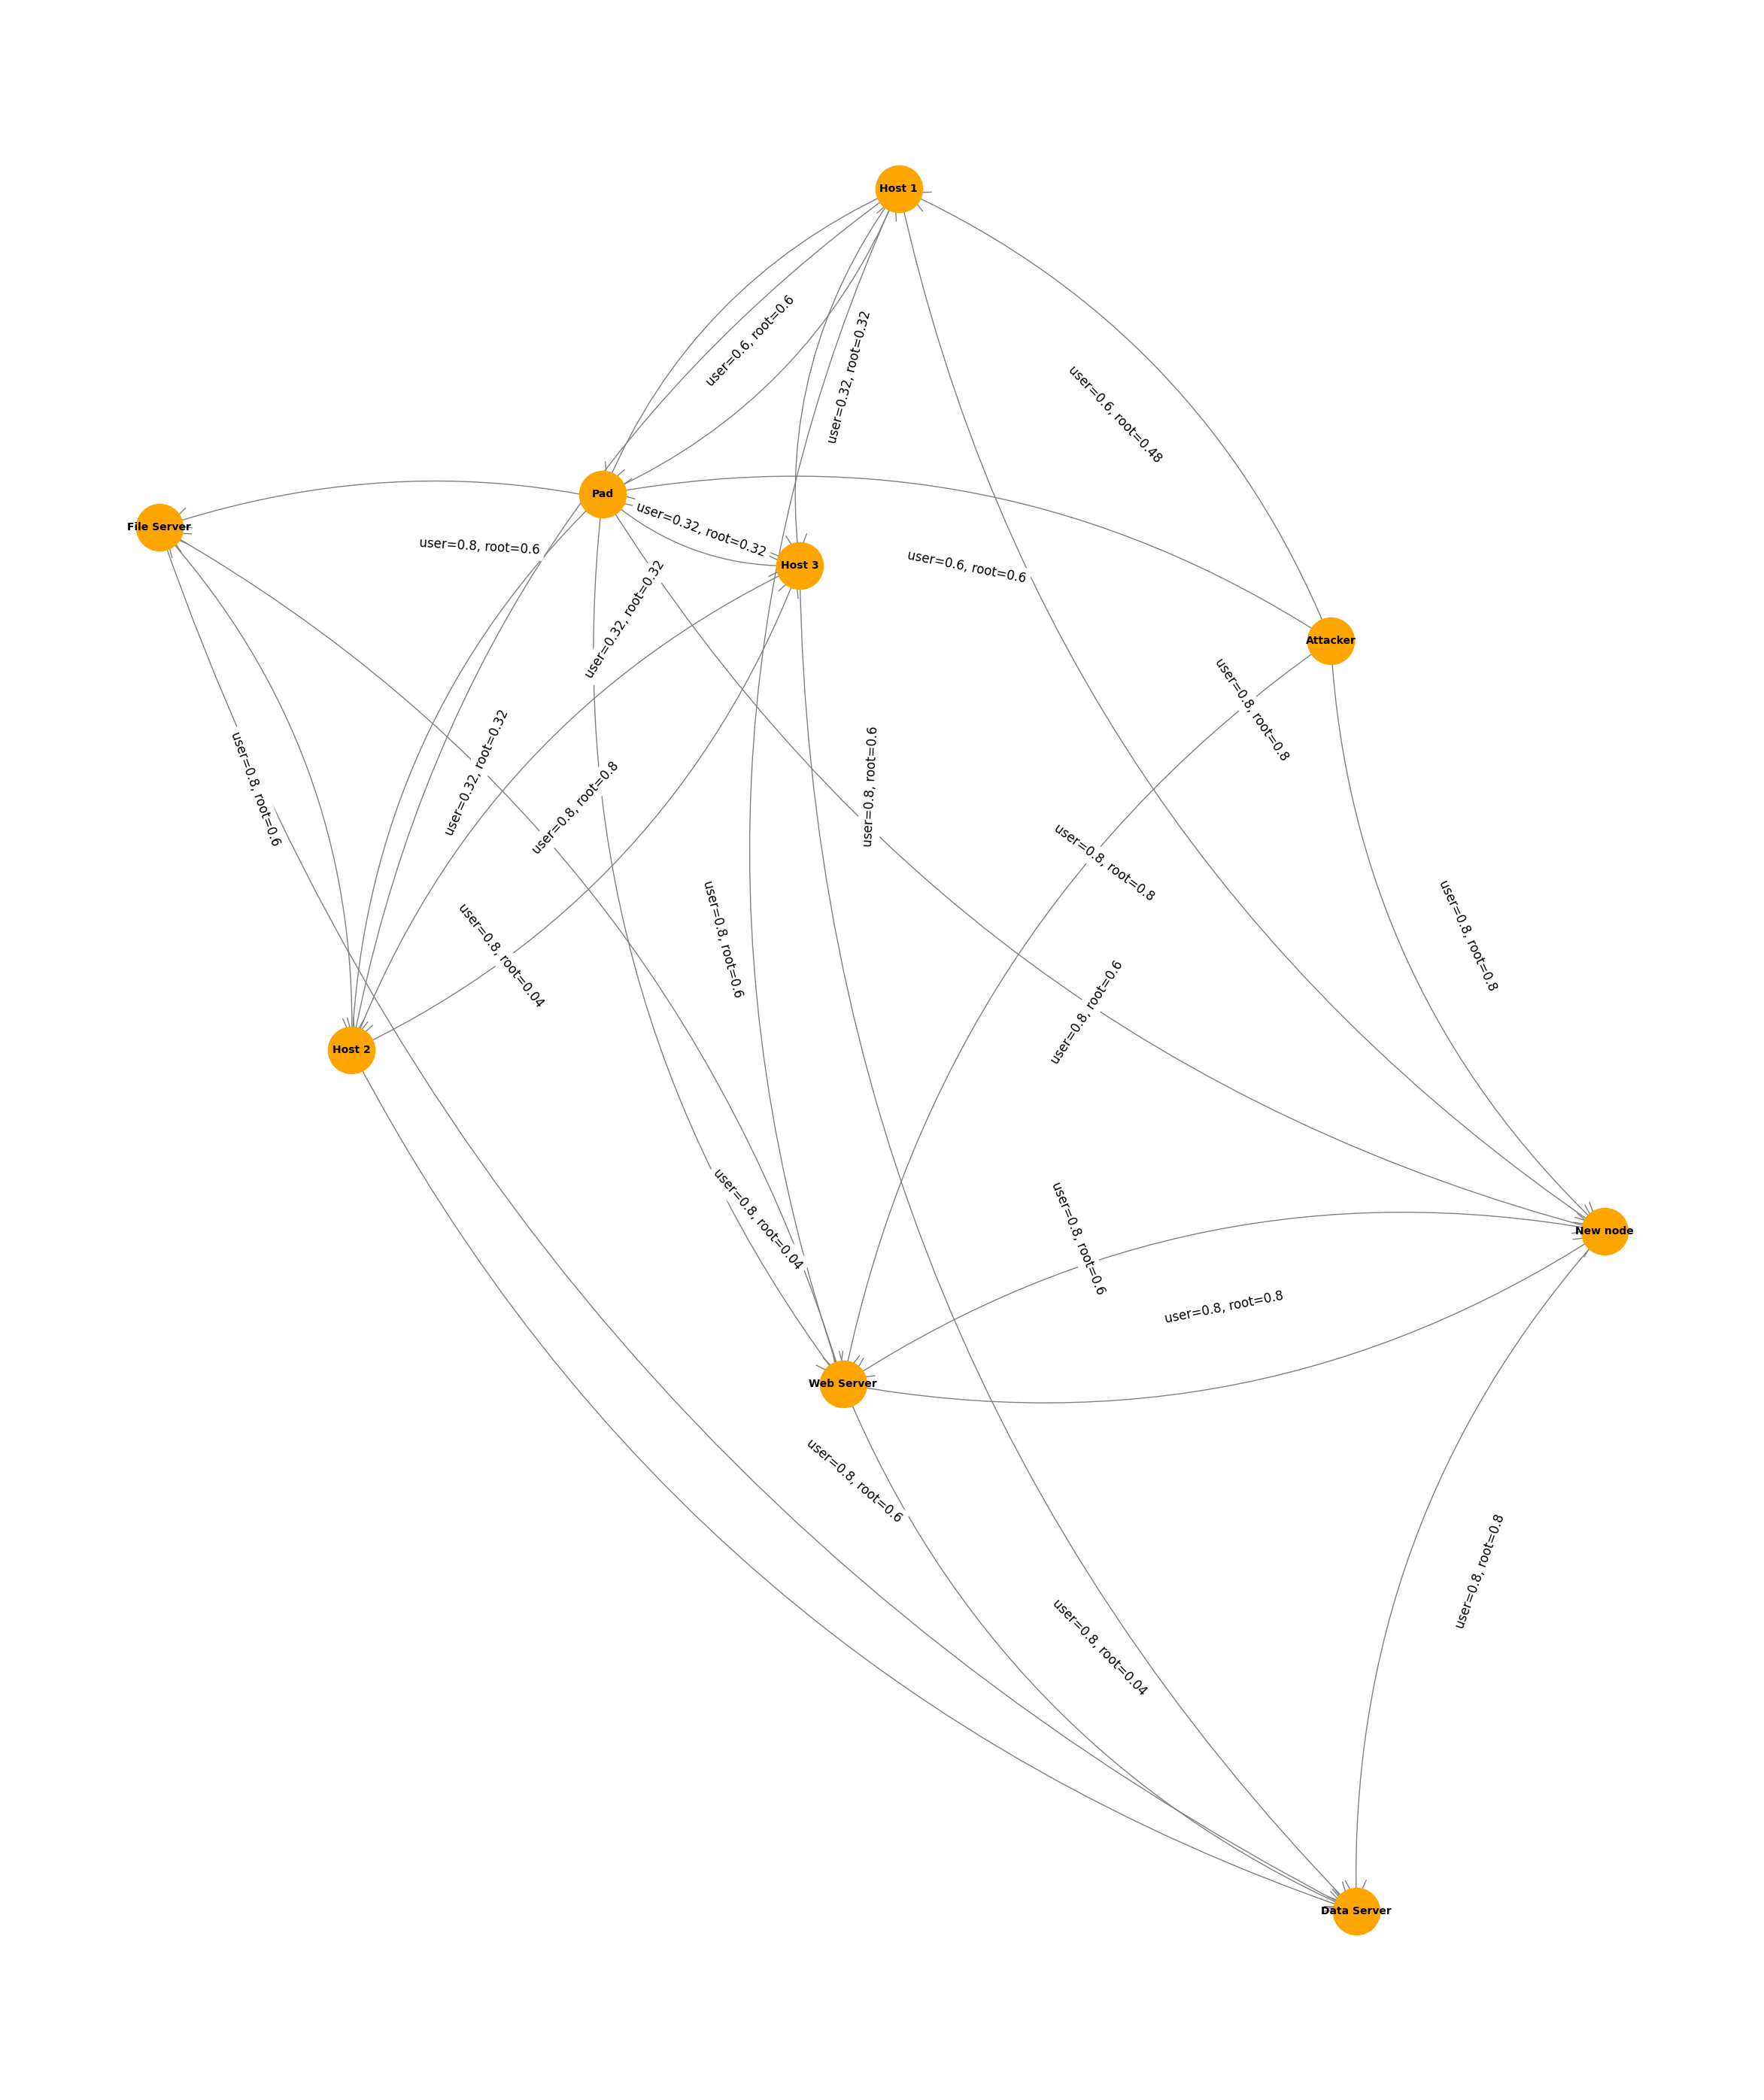

In [5]:
plt.figure(figsize=(30, 36))
pos = nx.spring_layout(G_original)

nx.draw_networkx_nodes(G_original, pos, node_color='orange', node_size=2000)
nx.draw_networkx_labels(G_original, pos, font_size=10, font_weight='bold')

nx.draw_networkx_edges(
    G_original, pos,
    edge_color='gray',
    arrows=True,
    arrowstyle='->',
    arrowsize=50,
    connectionstyle='arc3,rad=0.2'
)

# Vẽ nhãn trên cạnh
edge_labels = {(u, v): f"user={d['user']}, root={d['root']}" for u, v, d in G_original.edges(data=True)}
nx.draw_networkx_edge_labels(G_original, pos, edge_labels=edge_labels, font_size=12)

plt.axis('off')
plt.show()


In [6]:
# Initialize environment and train
algo = global_weighted_random_attack
# algo = greedy_attack_priority_queue
env = NetworkSecurityEnv(G_original, algo)
num_episode = 10000
model = train_dqn(env, num_episode)

node_to_idx: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6, 'New node': 7}
state_size 8
action_space_size 136
Episode 1000, Total Reward: -116, Epsilon: 0.010, Defense Success Probability: 0.442%

Honeypot 0 -> Web Server
Honeypot 1 -> New node

['Attacker', 'Host 1', 'New node', 'Web Server', 'Honeypot {Web Server}']
Saved model with best DSP 442 at episode 1000 to ./8-nodes model/dqn_model.pth
Episode 2000, Total Reward: 48, Epsilon: 0.010, Defense Success Probability: 0.524%

Honeypot 0 -> New node
Honeypot 1 -> Host 1

['Attacker', 'Host 1', 'New node', 'Honeypot {New node}']
Episode 3000, Total Reward: -28, Epsilon: 0.010, Defense Success Probability: 0.486%

Honeypot 0 -> Web Server
Honeypot 1 -> New node

['Attacker', 'Pad', 'Web Server', 'File Server', 'Host 1', 'Honeypot {Web Server}']
Saved model with best DSP 524 at episode 2000 to ./8-nodes model/dqn_model.pth
Episode 4000, Total Reward: -58, Epsilon: 0.010, Defense Su

In [7]:
evaluate_model(model,env)

Episode: 1
['Attacker', 'New node', 'Web Server', 'Pad', 'Host 1', 'Data Server']
Failed
Honeypots: [[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['New node', 'Web Server']

Episode: 2
['Attacker', 'New node', 'Pad', 'Honeypot {New node}']
Success
Honeypots: [[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['New node', 'Web Server']

Episode: 3
['Attacker', 'New node', 'Web Server', 'Honeypot {Web Server}']
Success
Honeypots: [[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['New node', 'Web Server']

Episode: 4
['Attacker', 'Pad', 'Web Server', 'Honeypot {Web Server}']
Success
Honeypots: [[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['New node', 'Web Server']

Episode: 5
['Attacker', 'New node', 'Web Server', 'Host 1', 'Data Server']
Failed
Honeypots: [[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['New node', 'Web Server']

Epis